### Import libraries and scripts

In [4]:
import image_processing
import deep_learning
import keras_tuner
import aux
import lstm
import numpy as np
from numpy import save
from numpy import load
import pandas as pd
import matplotlib.pyplot as plt

### Install the required libraries

pip install -r requirements.txt

### Initial Data Preparation steps

#### Read data with Week consumptions (168 hour), next day consumption cluster label [0,21] and 24 consecutive consumption hour for next day

In [5]:
colnames_ = ["consumer_id","day_id"]
w_list = ['w' + str(x) for x in range(0,168)]
colnames_.extend(w_list)
colnames_.append("next_day_cluster")
d_list = ['d' + str(x) for x in range(0,24)]
colnames_.extend(d_list)

data = pd.read_csv ("../data/data_mas400seguidos.csv",sep=";",header=None, names=colnames_)

#remove user id and consumption day id
#data = data.iloc[:,2:] 



### Weekly consumption that corresponds to infrequent clusters is eliminated

In [7]:
data.next_day_cluster.value_counts()

next_day_cluster
5     53823
0     46480
11    20031
3     12392
10     2734
12     2691
6      2108
16     2064
15     2003
19     1267
9      1111
13      902
8       832
14      740
17      667
2       457
18      215
7       129
4        52
20       24
1         2
Name: count, dtype: int64

### Remove observation on clusters 20,4, 1,7,18,2
**Too few observations for those clusters**

In [10]:
cluster_to_remove = [20,4,1,7,18,2]
df_filtered = data[~data.next_day_cluster.isin(cluster_to_remove)]
df_filtered.next_day_cluster.value_counts()

next_day_cluster
5     53823
0     46480
11    20031
3     12392
10     2734
12     2691
6      2108
16     2064
15     2003
19     1267
9      1111
13      902
8       832
14      740
17      667
Name: count, dtype: int64

In [11]:
df_filtered.next_day_cluster.unique()

array([11, 12,  5,  9,  0,  3, 10, 19, 17,  6, 16,  8, 13, 14, 15])

In [12]:
df = df_filtered.groupby("next_day_cluster", group_keys=False)

df_balanced = pd.DataFrame(df.apply(lambda x: x.sample(df.size().min()))).reset_index(drop=True)
df_balanced.next_day_cluster.value_counts()

next_day_cluster
0     667
3     667
5     667
6     667
8     667
9     667
10    667
11    667
12    667
13    667
14    667
15    667
16    667
17    667
19    667
Name: count, dtype: int64

In [13]:
df_balanced

,consumer_id,day_id,w0,w1,w2,w3,w4,w5,w6,w7,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,2453,486,227,97,271,96,261,278,231,77,...,180,136,1025,204,1865,4775,3482,1004,1333,716
1,6663,358,83,144,171,66,194,50,261,1122,...,984,1295,943,891,946,947,874,1185,963,488
2,4568,513,1962,265,148,273,261,145,238,404,...,940,2304,1467,706,737,915,848,624,1015,1069
3,3851,658,180,179,180,180,180,180,189,187,...,94,56,213,1618,1838,758,964,1048,732,420
4,5779,461,417,406,307,78,183,123,439,355,...,146,271,851,459,1880,1901,978,1003,1407,694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,2497,616,553,489,474,479,467,624,692,6089,...,488,623,633,738,666,1446,1374,1299,821,359
10001,6207,353,589,270,235,232,206,185,979,2477,...,611,640,689,965,592,633,581,763,1012,858
10002,6207,340,460,243,316,205,918,132,924,4666,...,2160,1210,1444,1641,1648,1477,1093,895,890,842
10003,2497,503,388,440,532,579,528,421,525,1010,...,546,532,618,573,664,546,660,1335,1429,1101


In [14]:
data = df_balanced

### Remove day id and consumer id row

In [15]:
data = data.iloc[:,2:] 
data

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23
0,227,97,271,96,261,278,231,77,238,66,...,180,136,1025,204,1865,4775,3482,1004,1333,716
1,83,144,171,66,194,50,261,1122,1334,1263,...,984,1295,943,891,946,947,874,1185,963,488
2,1962,265,148,273,261,145,238,404,545,422,...,940,2304,1467,706,737,915,848,624,1015,1069
3,180,179,180,180,180,180,189,187,1717,1043,...,94,56,213,1618,1838,758,964,1048,732,420
4,417,406,307,78,183,123,439,355,287,1162,...,146,271,851,459,1880,1901,978,1003,1407,694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,553,489,474,479,467,624,692,6089,3043,767,...,488,623,633,738,666,1446,1374,1299,821,359
10001,589,270,235,232,206,185,979,2477,2714,1458,...,611,640,689,965,592,633,581,763,1012,858
10002,460,243,316,205,918,132,924,4666,2710,641,...,2160,1210,1444,1641,1648,1477,1093,895,890,842
10003,388,440,532,579,528,421,525,1010,1286,765,...,546,532,618,573,664,546,660,1335,1429,1101


### Extract week consumptions

In [16]:
data_with_no_next_day_row = data.iloc[: , :-25]

In [17]:
data_with_no_next_day_row

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w158,w159,w160,w161,w162,w163,w164,w165,w166,w167
0,227,97,271,96,261,278,231,77,238,66,...,138,167,66,159,145,65,450,406,555,265
1,83,144,171,66,194,50,261,1122,1334,1263,...,1284,1408,1999,4480,3159,2232,5937,1975,1224,248
2,1962,265,148,273,261,145,238,404,545,422,...,208,222,371,364,798,659,589,848,1264,1014
3,180,179,180,180,180,180,189,187,1717,1043,...,1614,1838,676,2118,1881,1243,1145,908,684,317
4,417,406,307,78,183,123,439,355,287,1162,...,143,1275,2988,2424,925,828,1384,1175,1699,534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,553,489,474,479,467,624,692,6089,3043,767,...,386,456,351,274,261,387,1218,1400,872,422
10001,589,270,235,232,206,185,979,2477,2714,1458,...,391,359,411,375,523,983,668,647,676,626
10002,460,243,316,205,918,132,924,4666,2710,641,...,673,666,557,911,659,623,644,609,603,650
10003,388,440,532,579,528,421,525,1010,1286,765,...,567,710,900,1010,837,1523,1140,1538,1411,1115


### Get observations on each next_day_cluster 

<Axes: xlabel='next_day_cluster'>

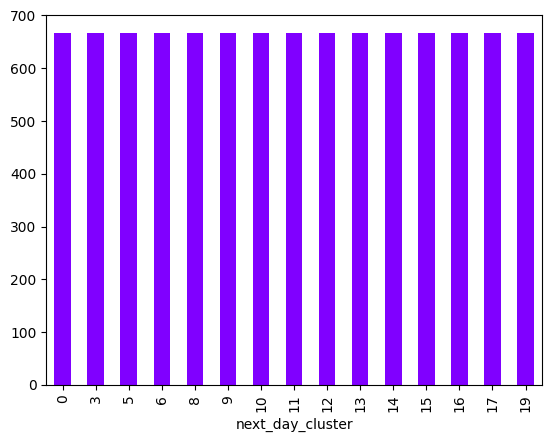

In [18]:

data.next_day_cluster.value_counts().plot(kind='bar',
                                          cmap='rainbow')

### Example of hourly consumptions time series for a week of a random consumer

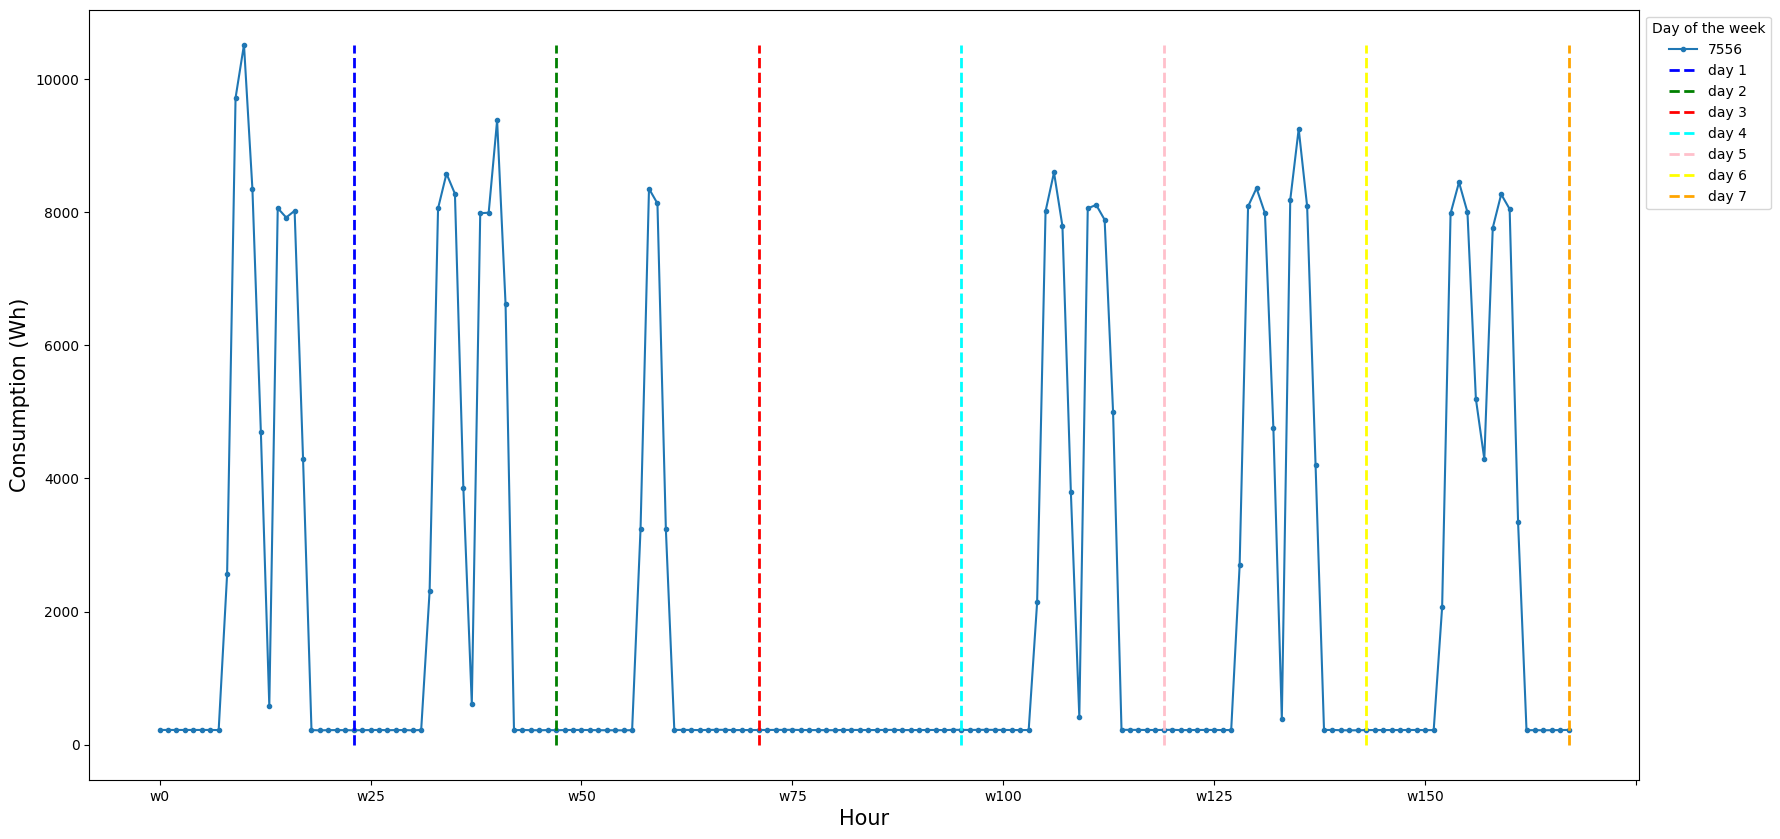

In [63]:
rowTS = (data_with_no_next_day_row.iloc[7556])
aux.plot_time_series_with_week_separator(rowTS)

### Centroids for next day curves

Load 21 centroid model from Ireland

In [20]:
centroids = [ [ 666.40479893,  484.33481247,  403.49585082,  370.5242449 ,
         363.99568771,  391.12255842,  496.10640185,  659.05330929,
         732.29261459,  661.01002998,  626.41878595,  557.36233516,
         555.74481743,  628.43159322,  623.64899298,  647.05002927,
         688.73262013,  989.96810246, 1397.61470245, 1526.12345439,
        1467.50739569, 1424.30494595, 1277.73625541, 1007.61093758],
 [7988.88639466, 7268.74730775, 6804.77445776, 6640.17503413,
        6434.40785682, 6337.86303655, 6328.51327165, 6650.20203246,
        7212.94342484, 7726.6173214 , 8306.49582891, 8685.71105718,
        9029.67844684, 8995.13635674, 9000.76566055, 8950.58956469,
        9127.54664038, 9296.29713332, 9482.04307599, 9707.37919005,
        9684.54300015, 9512.9323525 , 8907.89276505, 8432.03579554],
 [5063.53569443, 4365.20704993, 3896.86967641, 3597.82525297,
        3459.25408651, 3456.88007339, 3567.78494385, 3849.55665518,
        4187.1664628 , 4334.57300122, 4484.80946292, 4604.65072834,
        4891.90164572, 4842.72334038, 4875.54475703, 5077.23446014,
        5581.56388302, 6209.94340042, 6724.0742244 , 7015.64422328,
        7026.27376849, 6932.77082175, 6616.3797954 , 5979.58968086],
 [ 664.64971722,  484.24338371,  403.54985479,  369.60886776,
         362.38005281,  393.0481233 ,  495.5519526 ,  690.89894635,
         841.49293436,  824.32571513,  840.90577216,  814.3801635 ,
         856.04135019,  902.06588095,  901.49747788, 1392.20289267,
        2653.60199451, 2977.45762989, 1610.71474955, 1378.71938267,
        1351.9737931 , 1336.13024388, 1202.78810991,  964.67879676],
 [8317.06892543, 8494.768477  , 8141.3019432 , 7593.31971433,
        6861.97176549, 6048.78790899, 5365.8445441 , 4482.35459226,
        2397.45523999, 2033.88739412, 2330.18285999, 2274.50357084,
        2217.54658695, 2044.82710513, 2013.83341638, 1976.31772131,
        1890.80468361, 1553.51934895, 1301.88290982, 1304.58379007,
        1332.65819631, 1404.31954825, 1763.12771965, 5746.45308088],
 [320.96178046, 255.8529408 , 229.07278026, 219.64003234,
        219.84097373, 230.34301883, 278.94034518, 365.18098082,
        400.59031706, 395.79920081, 372.54551802, 340.40825456,
        343.47485796, 352.78843204, 339.48136236, 350.84684382,
        383.45530162, 445.23904749, 459.05602476, 460.7941184 ,
        481.0623598 , 508.57178647, 488.21405724, 411.43217114],
 [ 744.03409614,  531.72816415,  450.16188436,  419.39059399,
         413.72691544,  434.3549074 ,  511.50830058,  770.96687654,
        2036.33027511, 4275.53008057, 2376.44072609, 1269.39402463,
        1136.45864168, 1099.6225371 , 1008.03069178, 1040.88979876,
        1179.39464241, 1439.46789521, 1541.92177868, 1564.42676691,
        1509.7273492 , 1470.47353409, 1314.84056047, 1037.55479173],
 [1601.16603784, 1170.65591189,  959.14439882,  878.8354325 ,
         843.33421184,  861.24551961, 1003.8459191 , 1423.54288964,
        2003.28488598, 2671.09454586, 3392.50585363, 3846.09160517,
        4295.97386673, 4593.98673917, 4619.61335516, 4631.94401598,
        4846.79961716, 5423.64528658, 5400.69708151, 4917.79620485,
        4308.65682739, 3766.67399989, 3124.9490096 , 2392.10758475],
 [3143.24018488, 2796.65769111, 2539.80058164, 2408.06945887,
        2377.95899979, 2403.00059722, 2524.84233486, 2824.19295285,
        2941.967984  , 2819.09906003, 2755.33350644, 2713.53733901,
        2693.8324678 , 2662.73995118, 2571.32922206, 2558.56930307,
        2656.32319796, 2854.96917844, 2976.30460636, 2999.86770357,
        3070.49085999, 3190.84841088, 3166.72546219, 3052.21214167],
 [ 924.00874251,  661.89334664,  548.39566201,  500.16010645,
         487.6160346 ,  507.34621424,  590.92546906,  818.70312708,
        1197.05776447, 1920.45172322, 4071.36357951, 4294.43602129,
        2469.61630073, 1647.86794411, 1424.84790419, 1408.84958084,
        1557.61201597, 1876.66726547, 1996.53409182, 2021.52737192,
        1928.34179641, 1826.09276114, 1607.99800399, 1261.05015303],
 [ 812.21019229,  574.68051668,  472.65269536,  433.00153241,
         427.64155564,  469.31139442,  633.07503918,  959.77076803,
        1098.21715461,  991.33350593,  982.19459528,  955.48468988,
         992.90856611, 1049.9502701 ,  969.16469576, 1005.36742891,
        1312.31778997, 2916.27394481, 4615.82014107, 3177.27366491,
        2249.42958604, 1897.53034035, 1592.4525932 , 1210.68650638],
 [ 642.57734751,  483.99367229,  403.49586352,  370.68959448,
         359.51990161,  370.07461016,  416.89810214,  523.60774039,
         728.8428407 ,  929.33392458, 1341.47870377, 1737.51633606,
        2046.35477174, 1563.61767427, 1046.05980638,  909.43473924,
         878.26403538,  957.53414122,  980.66428813,  948.69999323,
         956.18663598,  993.69464491,  951.83177397,  803.69112901],
 [ 878.4607494 ,  650.14644639,  533.69427373,  472.9124521 ,
         452.51305039,  463.77182597,  528.63582713,  700.44790688,
         930.56599306, 1070.47802943, 1222.95578772, 1297.33524329,
        1498.10612031, 2541.81275757, 3764.96807895, 3080.80275287,
        1989.60919312, 1668.09438038, 1638.56510737, 1642.48099378,
        1590.33541501, 1571.93889632, 1436.67476141, 1183.35150206],
 [1214.39438737, 1128.04979955, 1082.22638436, 1067.5663994 ,
        1058.08312453, 1050.55712854, 1090.87214984, 1445.62189927,
        3157.46172638, 7300.26265347, 8970.56746429, 9258.00745427,
        9114.90967176, 8316.58926334, 8724.38893761, 8678.63148334,
        8195.13248559, 6048.81589827, 2487.61644951, 1572.3070659 ,
        1318.12722375, 1259.56840391, 1214.6663117 , 1195.21485843],
 [3727.43318769, 3534.45903878, 3398.14127071, 3392.89249954,
        3368.24003277, 3374.38494447, 3544.37156381, 4360.42799927,
        6742.08747497, 9087.88376115, 9860.98124886, 9872.27571455,
        9851.59894411, 9491.13890406, 9352.42508647, 9260.12980157,
        9077.31139632, 7964.41307118, 6086.85882032, 5149.9208083 ,
        4354.26697615, 3901.54951757, 3563.21017659, 3571.9576734 ],
 [ 913.61542846,  781.63053205,  724.87335784,  706.45008692,
         704.80832692,  716.9262489 ,  825.49348836, 1145.99270468,
        2275.2919837 , 4475.50676812, 5440.60058135, 5554.70519506,
        5347.03126158, 4596.07266821, 4666.11293494, 4441.23652788,
        4042.72155253, 2942.87446924, 1637.88943034, 1323.41953777,
        1210.021373  , 1164.52400901, 1074.35912342,  965.97936793],
 [1104.78540487,  744.46498413,  585.5849443 ,  523.93598681,
         506.04348665,  541.99653327,  676.98950022,  969.2010145 ,
        1072.42832514,  945.66657746,  950.52198917,  937.85971868,
         967.88452107, 1014.9711396 ,  960.02245597, 1022.0998444 ,
        1160.32115516, 1427.85995519, 1800.21212423, 2745.17020601,
        3488.90814713, 3503.88833634, 2835.28454596, 1999.12927118],
 [1046.19702105,  743.46590955,  592.95869175,  524.10774715,
         499.38476497,  514.20733799,  593.71533901,  795.06843747,
        1088.80015664, 1319.82150622, 1615.09671452, 2615.47429544,
        4912.85032342, 3966.45790177, 2197.99292399, 1708.58566162,
        1698.25493903, 2016.31886622, 2229.6629306 , 2262.28522815,
        2153.13864394, 2075.5511458 , 1831.67612386, 1454.3954195 ],
 [1076.95739708,  767.7100562 ,  624.48005518,  558.85659564,
         539.21520344,  573.39004982,  735.66330358, 1175.04610281,
        1454.24856071, 1441.21697048, 1483.09184081, 1487.34782311,
        1584.88762726, 1790.97665219, 2100.87661457, 3135.88287333,
        4713.39260349, 4781.55077123, 3304.97372231, 2832.91886407,
        2614.59946191, 2434.11538242, 2092.13811462, 1608.12465087],
 [ 899.11416455,  684.02896997,  603.9178668 ,  582.95995188,
         597.02198954,  686.6068089 , 1234.00469333, 3534.1331761 ,
        2925.28366032, 1326.86539447, 1014.67541007,  952.45652718,
        1004.1651598 , 1033.69487427,  984.78516718, 1098.29171283,
        1332.94560983, 1725.28576874, 1808.8681104 , 1860.87802118,
        1773.77294548, 1722.19795352, 1549.18947218, 1225.38493609],
 [1433.63696948,  960.17417448,  757.08174241,  685.69120275,
         667.90362613,  713.51926642,  934.18354462, 1577.26653973,
        1825.25386247, 1631.31427569, 1592.29403217, 1551.69000017,
        1578.45990546, 1631.1542483 , 1610.63678576, 1772.0194418 ,
        2343.52502881, 3659.63499858, 4914.64129545, 5772.12142774,
        5439.95091113, 4704.81967898, 3740.83264018, 2635.09949725] ]

Convert list with centroids to time series data frame

In [21]:
dfCentroids = pd.DataFrame(centroids, columns = [*range(0, 24, 1)] ) 
dfCentroids = dfCentroids.round(0)
dfCentroids = dfCentroids.astype(int)
dfCentroids

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,666,484,403,371,364,391,496,659,732,661,...,624,647,689,990,1398,1526,1468,1424,1278,1008
1,7989,7269,6805,6640,6434,6338,6329,6650,7213,7727,...,9001,8951,9128,9296,9482,9707,9685,9513,8908,8432
2,5064,4365,3897,3598,3459,3457,3568,3850,4187,4335,...,4876,5077,5582,6210,6724,7016,7026,6933,6616,5980
3,665,484,404,370,362,393,496,691,841,824,...,901,1392,2654,2977,1611,1379,1352,1336,1203,965
4,8317,8495,8141,7593,6862,6049,5366,4482,2397,2034,...,2014,1976,1891,1554,1302,1305,1333,1404,1763,5746
5,321,256,229,220,220,230,279,365,401,396,...,339,351,383,445,459,461,481,509,488,411
6,744,532,450,419,414,434,512,771,2036,4276,...,1008,1041,1179,1439,1542,1564,1510,1470,1315,1038
7,1601,1171,959,879,843,861,1004,1424,2003,2671,...,4620,4632,4847,5424,5401,4918,4309,3767,3125,2392
8,3143,2797,2540,2408,2378,2403,2525,2824,2942,2819,...,2571,2559,2656,2855,2976,3000,3070,3191,3167,3052
9,924,662,548,500,488,507,591,819,1197,1920,...,1425,1409,1558,1877,1997,2022,1928,1826,1608,1261


**Plot centroids**

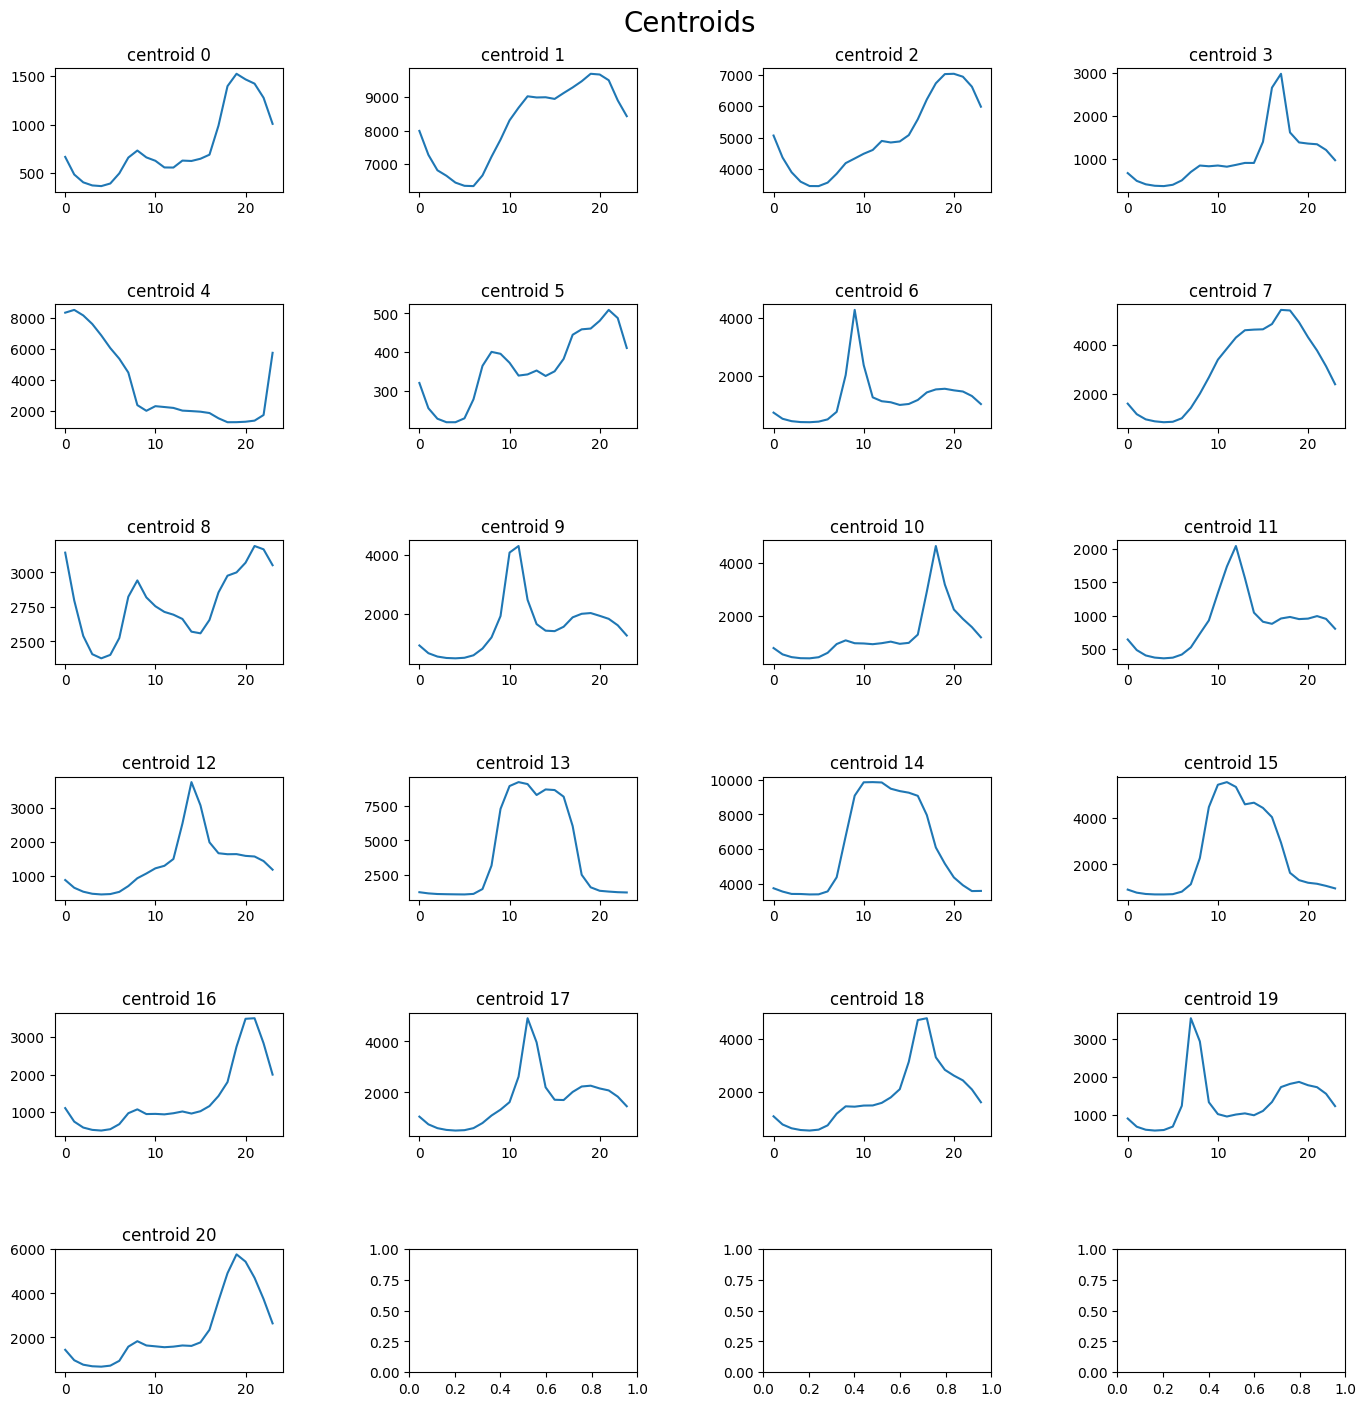

In [22]:
M =6
N= 4
fig, axs = plt.subplots(M, N,figsize=(15,15))
fig.tight_layout(pad=6.0)
fig.suptitle('Centroids', fontsize=20)
centroids_id = 0
for i in range(M):
    for j in range(N):
            if centroids_id<len(centroids):
                axs[i,j].plot(dfCentroids.iloc[centroids_id])
                axs[i, j].set_title("centroid " + str(centroids_id))
                centroids_id+=1

## Imaging Time Series

### Modelling Neural Network Input Week Time series as 2D images

Each weekly consumption time series is converted to a 2D image format that can be manipulated by the deep learning algorithms. RGB channel will be created with GRAM summ, GRAM diff and markov time series images.

**Example of one week consumption of time series dataframe in Gramm diff, Gramm summ and Markov transformed time series image**

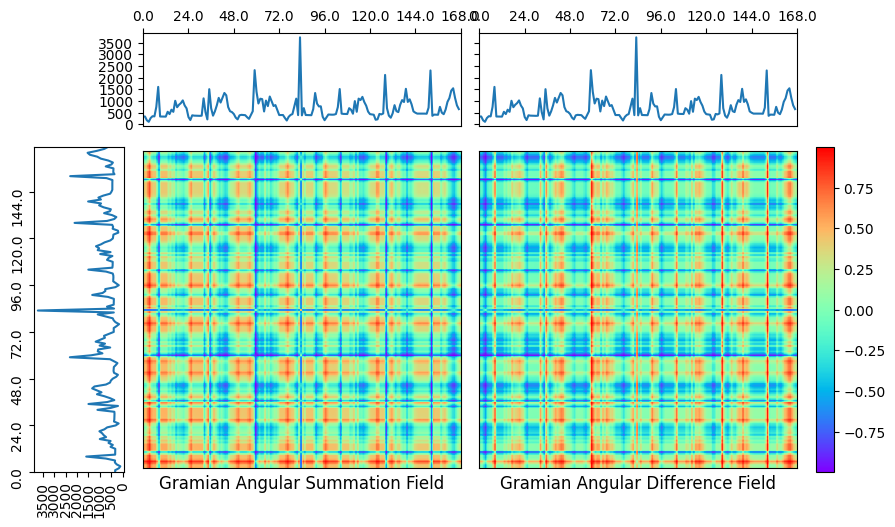

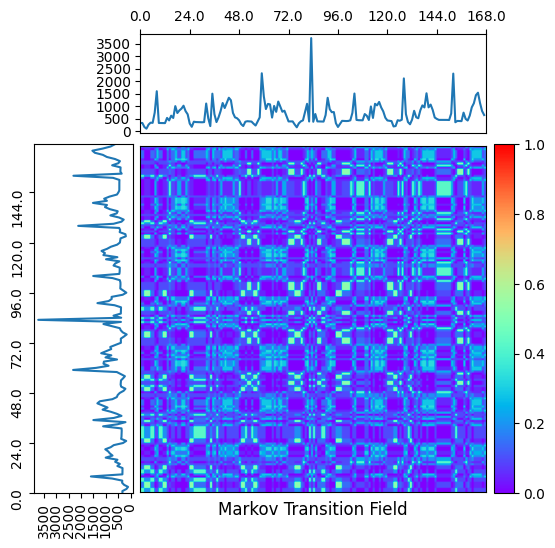

In [61]:
ts_week = data_with_no_next_day_row.iloc[249]
gaf_ts_diff = image_processing.transform_image_with_gram_angular_field(ts_week, method='difference')

gaf_ts_sum = image_processing.transform_image_with_gram_angular_field(ts_week, method='summation')

markov_ts = image_processing.transform_image_with_markov(ts_week)

image_processing.plot_gram_angular_field(ts_week,gaf_ts_sum, gaf_ts_diff)
image_processing.plot_markov(ts_week,markov_ts)


## Data preparation for time series imaging deep learning

### Split data on validation and test

In [72]:
from sklearn.model_selection import train_test_split
labels = data["next_day_cluster"]
x_train, x_valid, y_train, y_valid = aux.split_data(data_with_no_next_day_row,labels)

In [74]:
x_train

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w158,w159,w160,w161,w162,w163,w164,w165,w166,w167
7556,222,222,221,222,222,222,222,220,2560,9717,...,7766,8270,8049,3344,218,219,217,219,222,222
6361,2070,2069,2064,2062,2077,2101,2045,3349,7041,8071,...,7680,7768,8012,7488,4205,3124,1869,1882,1901,1903
4876,75,75,60,60,77,77,93,604,363,502,...,1209,333,263,435,395,347,210,331,622,303
3949,251,82,251,70,260,87,231,195,880,1133,...,3060,1126,970,635,440,244,110,254,127,247
3163,3108,3178,3168,3122,3154,3161,3143,3091,3055,3146,...,5406,5466,6055,6141,6041,4093,3261,3236,3199,3238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,439,526,483,455,560,388,3655,3975,1169,683,...,1537,507,604,568,530,668,678,569,626,697
7329,3226,3226,3185,3219,3144,3188,3272,3139,6417,8356,...,9137,9219,8758,8252,7680,3569,3386,3396,3438,3499
2984,1852,2058,1938,1862,1896,1887,1842,1895,1832,2200,...,2985,2065,2013,2100,2042,2304,2100,2238,1900,1670
9118,1397,925,613,427,544,527,429,589,463,505,...,802,658,801,795,1518,775,613,588,474,701


In [75]:
y_train

7556    15
6361    13
4876    11
3949     9
3163     8
        ..
9466    19
7329    14
2984     8
9118    17
610      0
Name: next_day_cluster, Length: 7503, dtype: int64

In [76]:
data.iloc[7556]

w0     222
w1     222
w2     221
w3     222
w4     222
      ... 
d19    225
d20    224
d21    224
d22    225
d23    223
Name: 7556, Length: 193, dtype: int64

### Calculate Gram Angular and Markov images for training and val sets

In [76]:
input_nn_diff_train = x_train.apply( 
    image_processing.transform_image_with_gram_angular_field,
    axis=1)

input_nn_sum_train = x_train.apply( 
    image_processing.transform_image_with_gram_angular_field,method="summation",
    axis=1)

input_nn_markov_train = x_train.apply( 
    image_processing.transform_image_with_markov,
    axis=1)

input_nn_diff_valid = x_valid.apply( 
    image_processing.transform_image_with_gram_angular_field,
    axis=1)

input_nn_sum_valid= x_valid.apply( 
    image_processing.transform_image_with_gram_angular_field,method="summation",
    axis=1)

input_nn_markov_valid = x_valid.apply( 
    image_processing.transform_image_with_markov,
    axis=1)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins wi

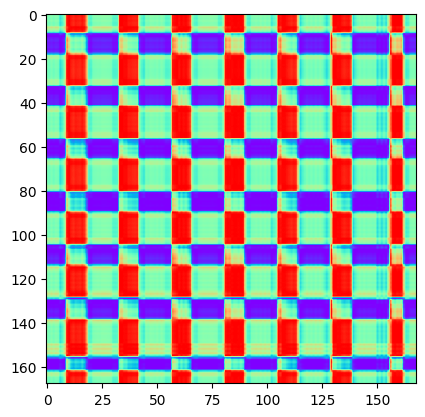

In [88]:
plt.imshow(input_nn_diff_train.iloc[0],cmap='rainbow')

### Save input (week consumption on Gram matrix format) as PNG images 

**Execute next cells if you want to save images GRAM SUMM, GRAM DIFF and MARKOV for all weekly consumption series in the corresponding next day cluster label. Not recommended if there are a big number of weekly consumptions observations**

Create a folder structure to store the weekly images in Gram domain that belong to each class
|next_day_cluster_0| ... |next_day_cluster_n|

In [84]:
next_day_clusters = data.next_day_cluster.unique()
aux.create_folder_structure(next_day_clusters)

Saves three channel images for each weekly consumption time serie in the corresponding folder according to the cluster class of the next day of consumption (for training data. It is done only to have image examples). 

In [85]:
labels = y_train.values
image_processing.save_three_channels_images(input_nn_diff_train[0:9],input_nn_sum_train[0:9],input_nn_markov_train[0:9], labels=labels)

## Train Deep Learning model

Create an instance of deep learning object with basic params setting for machine learning process

In [117]:
import deep_learning
dl = deep_learning.DeepLearning(
    img_width = 168,
    img_height = 168,
    img_channels = 3,
    epochs = 10,
    num_classes = len(data.next_day_cluster.unique())
)

## Create 3 channel images train and validation datasets

In [90]:
(diff_train, sum_train_, mk_train) = aux.create_three_channel_dataset(x_train,
                                       input_nn_diff_train,
                                       input_nn_sum_train,
                                       input_nn_markov_train)

In [91]:
(diff_val, sum_val_, mk_val) = aux.create_three_channel_dataset(x_valid,
                                       input_nn_diff_valid,
                                       input_nn_sum_valid,
                                       input_nn_markov_valid)

In [93]:
print(diff_train.shape)
print(sum_train_.shape)
print(mk_train.shape)
print(diff_val.shape)
print(sum_val_.shape)
print(mk_val.shape)

(7503, 168, 168)
(7503, 168, 168)
(7503, 168, 168)
(2502, 168, 168)
(2502, 168, 168)
(2502, 168, 168)


### Prepare deep learning input channels data structure

In [94]:
x_train_dl = np.concatenate((np.expand_dims(sum_train_, axis=3),np.expand_dims(diff_train, axis=3), np.expand_dims(mk_train, axis=3)), axis=3)
x_train_dl.shape

(7503, 168, 168, 3)

In [95]:
x_val_dl = np.concatenate((np.expand_dims(sum_val_, axis=3),np.expand_dims(diff_val, axis=3), np.expand_dims(mk_val, axis=3)), axis=3)
x_val_dl.shape

(2502, 168, 168, 3)

In [ ]:
y_valid

### Save neural input data

In [96]:
base_url = '../data/train_vals_numpy/'
save(f'{base_url}/x_train_dl.npy', x_train_dl)
save(f'{base_url}/x_val_dl.npy', x_val_dl)

In [80]:
y_train.to_csv(f'{base_url}/y_train.csv')
y_valid.to_csv(f'{base_url}/y_valid.csv')

### Read input neural data

In [31]:
base_url = '../data/train_vals_numpy/'
x_train_dl = load(f'{base_url}/x_train_dl.npy')
x_val_dl = load(f'{base_url}/x_val_dl.npy')

In [32]:
y_train = pd.read_csv (f'{base_url}/y_train.csv',sep=";",header=None, names=colnames_)
y_valid = pd.read_csv (f'{base_url}/y_valid.csv',sep=";",header=None, names=colnames_)

In [45]:
x_train_dl.shape

(7503, 168, 168, 3)

In [53]:
print(x_train_dl.ndim)

4


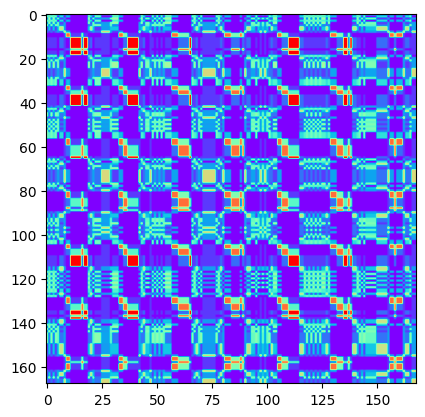

In [57]:
plt.imshow(x_train_dl[0,:,:,2],cmap='rainbow')
image_processing.plot_gram_angular_field(ts_week,x_train_dl[0,:,:,0], x_train_dl[0,:,:,1])
image_processing.plot_markov(ts_week,x_train_dl[0,:,:,2])

### One hot coding for each class (train and validation data -Y-)

In [86]:
one_hot_train = pd.get_dummies(y_train)
one_hot_val = pd.get_dummies(y_valid)
one_hot_train
#train_target = train_target.values.reshape(3205,1)

,0,3,5,6,8,9,10,11,12,13,14,15,16,17,19
7556,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
6361,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4876,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3949,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3163,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
7329,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2984,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
9118,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [123]:
tuner = dl.get_tuner(keras_tuner.HyperParameters())

In [124]:
stop_early = dl.get_early_stopping()

In [132]:
x_train_dl[0,:,:,2]

array([[0.0952381 , 0.38095238, 0.0952381 , ..., 0.0952381 , 0.14285714,
        0.14285714],
       [0.31818182, 0.27272727, 0.31818182, ..., 0.31818182, 0.        ,
        0.        ],
       [0.0952381 , 0.38095238, 0.0952381 , ..., 0.0952381 , 0.14285714,
        0.14285714],
       ...,
       [0.0952381 , 0.38095238, 0.0952381 , ..., 0.0952381 , 0.14285714,
        0.14285714],
       [0.1       , 0.05      , 0.1       , ..., 0.1       , 0.45      ,
        0.45      ],
       [0.1       , 0.05      , 0.1       , ..., 0.1       , 0.45      ,
        0.45      ]])

In [127]:

tuner.search(x_train_dl[0:1023], one_hot_train[0:1023],
                epochs=dl.epochs, 
                batch_size=32,
                validation_data=(x_val_dl[0:1023],one_hot_val[0:1023]),
                callbacks=[stop_early])

Trial 10 Complete [00h 00m 21s]
val_accuracy: 0.07820136845111847

Best val_accuracy So Far: 0.3646138906478882
Total elapsed time: 00h 07m 50s


 Train models with hyperparameter tuning and show results for best model selection

[INFO] optimal number of filters in conv_1 layer: 32
[INFO] optimal number of filters in conv_2 layer: 32
[INFO] optimal number of units in dense layer: 64
[INFO] optimal learning rate: 0.0010
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - accuracy: 0.1417 - loss: 4.2575 - val_accuracy: 0.2690 - val_loss: 2.3195
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.3099 - loss: 2.0563 - val_accuracy: 0.3120 - val_loss: 2.0510
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.3860 - loss: 1.7564 - val_accuracy: 0.3410 - val_loss: 1.9780
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.4611 - loss: 1.5391 - val_accuracy: 0.3370 - val_loss: 1.9895
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.5071 - loss: 1.4408 - val_accuracy: 0.3540 - val_loss: 2.0142
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.6183 - loss: 1.1369 - val_accuracy: 0.3390 - val_loss: 2.1082
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 

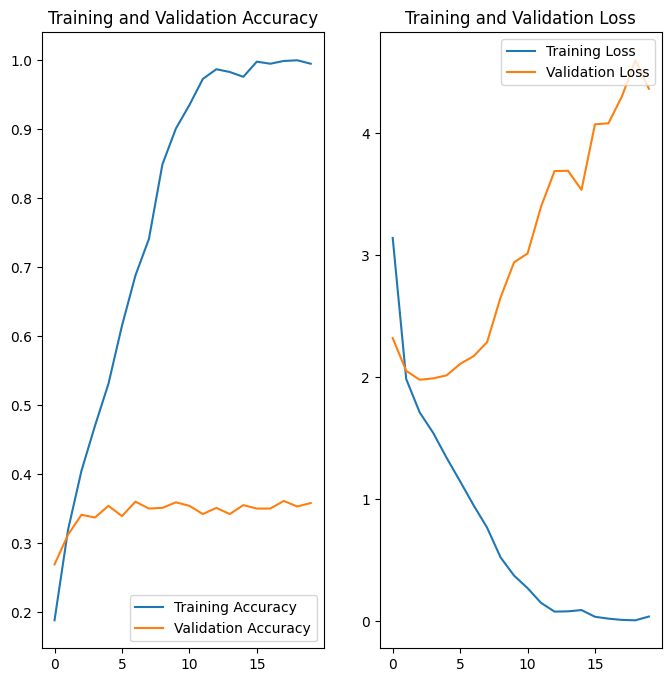

Best epoch: 18


In [116]:
import keras_tuner

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

## PRINT best hyperparameters values

print("[INFO] optimal number of filters in conv_1 layer: {}".format(
best_hps.get("conv_1")))
print("[INFO] optimal number of filters in conv_2 layer: {}".format(
best_hps.get("conv_2")))
print("[INFO] optimal number of units in dense layer: {}".format(
best_hps.get("dense_units")))
print("[INFO] optimal learning rate: {:.4f}".format(
best_hps.get("learning_rate")))

#train best model
model = dl.tuner.hypermodel.build(best_hps)
history = model.fit(x_train_dl[0:1000],one_hot_train[0:1000], epochs=dl.epochs,validation_data=(x_val_dl[0:1000],one_hot_val[0:1000]))
#show train and validation best model results
dl.show_results(history)

#train best model with best epoch
#dl.epochs = dl.best_epoch
#hypermodel = dl.tuner.hypermodel.build(best_hps)


### LSTM

### Prepare data for lstm model training

In [27]:
train_size = int(len(data_with_no_next_day_row) * 0.90)
train_data, test_data = data_with_no_next_day_row[:train_size], data_with_no_next_day_row[train_size:]

df_lstm_train = aux.prepare_data_for_lstm(train_data)
df_lstm_test = aux.prepare_data_for_lstm(test_data)

NameError: name 'data_with_no_next_day_row' is not defined

In [28]:
lstm = lstm.LSTM(history=168,future=24)

In [29]:
(x_train,y_train) = lstm.create_sequences(df_lstm_train)
(x_test,y_test) = lstm.create_sequences(df_lstm_test)

NameError: name 'df_lstm_train' is not defined

In [30]:
y_train

NameError: name 'y_train' is not defined

### Reshape x_train for NN LSTM

In [31]:
x_train_rsh =  np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train_rsh.shape

NameError: name 'x_train' is not defined

In [32]:
x_train_rsh.shape

NameError: name 'x_train_rsh' is not defined

### Asign reshape df to lstm object

In [33]:
lstm.train_ds = x_train_rsh

NameError: name 'x_train_rsh' is not defined

### Save lstm data (full dataset)

In [34]:
import os  
os.makedirs('../data/lstm', exist_ok=True)  
df_lstm = aux.prepare_data_for_lstm(data_with_no_next_day_row)
(x,y) = lstm.create_sequences(df_lstm)
x_pd = pd.DataFrame(x)
y_pd = pd.DataFrame(y)
x_pd.to_csv('../data/lstm/history.csv') 
y_pd.to_csv('../data/lstm/future.csv') 

NameError: name 'data_with_no_next_day_row' is not defined

### Build model, train and evaluate

In [35]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## No tuner
sc = MinMaxScaler(feature_range=(0,1))
x_train_scaled = sc.fit_transform(x_train)
y_train_scaled = sc.fit_transform(y_train)
x_test_scaled = sc.fit_transform(x_test)
y_test_scaled = sc.fit_transform(y_test)
bla = lstm.build_m2()
bla.fit(x_train_scaled,y_train_scaled)
pred = bla.predict(x_train_scaled, verbose=0)
prediction_no_scaled= sc.inverse_transform(pred)
aux.plot_predicted_over_real(6,prediction_no_scaled,y_test)


NameError: name 'x_train' is not defined

In [36]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
x_train_scaled = sc.fit_transform(x_train)
y_train_scaled = sc.fit_transform(y_train)
x_test_scaled = sc.fit_transform(x_test)
y_test_scaled = sc.fit_transform(y_test)

tuner = lstm.get_tuner(keras_tuner.HyperParameters())

stop_early = lstm.get_early_stopping()

tuner.search(
        x=x_train_scaled,
        y=y_train_scaled,
        epochs=20,
        batch_size=128,
        validation_data=(x_test_scaled,y_test_scaled),
        callbacks=[stop_early]
)




NameError: name 'x_train' is not defined

In [37]:
best_model = tuner.get_best_models(1)[0]

predictions=best_model.predict(x_test_scaled)

prediction_no_scaled= sc.inverse_transform(predictions)

aux.plot_predicted_over_real(6,prediction_no_scaled,y_test)

# Evaluate the model
mse = np.mean((prediction_no_scaled - y_test) ** 2)
print("Mean Squared Error:", mse)


NameError: name 'tuner' is not defined

In [38]:
plt.plot(prediction_no_scaled[33], color='red', label='predicted', marker='o')
plt.plot(y_test[33], color='green', label='real', marker='o')
plt.legend()
plt.show()

NameError: name 'prediction_no_scaled' is not defined

In [39]:
plt.plot(prediction_no_scaled[200],color="red")
plt.plot(prediction_no_scaled[256],color="green")
#plt.plot(prediction_no_scaled[2], color = "orange")

NameError: name 'prediction_no_scaled' is not defined

In [40]:
predictions=best_model.predict(x_train_scaled)

prediction_no_scaled= sc.inverse_transform(predictions)

aux.plot_predicted_over_real(6,prediction_no_scaled,y_train)


NameError: name 'best_model' is not defined

In [41]:
y_train_scaled

NameError: name 'y_train_scaled' is not defined

In [42]:
plt.plot(predictions[0])

NameError: name 'predictions' is not defined

In [43]:
y_test[0]

NameError: name 'y_test' is not defined

In [44]:
aux.plot_predicted_over_real(6,prediction_no_scaled,y_test)

NameError: name 'prediction_no_scaled' is not defined

In [45]:
plt.plot(predictions)

NameError: name 'predictions' is not defined

In [46]:
for i in range(4):
    plt.figure()
    plt.plot(prediction_no_scaled[i], color='red', label='predicted')
    plt.plot(y_test[i], color='green', label='real')
    plt.legend()
    plt.show()

NameError: name 'prediction_no_scaled' is not defined

<Figure size 640x480 with 0 Axes>

### Preprocessing CSV's ISIDRO

- Obtain the ids of consumers who have daily consumption assigned to a range of between 6 and 10 clusters and consecutive daily consumption of at least 400 days

In [ ]:
data = pd.read_csv ("../data/secuencia_patrones_6-10_400.csv",sep=",", header="infer")
user_ids = data.ID.unique()
user_ids

- Obtain how many daily consumptions have been assigned to the different daily clusters for each of the consumers who verify the previous conditions

In [ ]:
data_2 = pd.read_csv ("../data/filtered_6-10_users_centroids.csv",sep=",", header="infer")
data_2 = data_2[data_2.ID.isin(user_ids)]
data_2

- Filter users who do not use any of the clusters for more than 60% of observations (total number of days of consumption).

In [47]:
cols = data_2.columns[1:22].values
data_2['cut_value'] = 0.6*data_2[cols].sum(axis=1)
data_2

NameError: name 'data_2' is not defined

In [48]:
cols

NameError: name 'cols' is not defined

In [49]:
result = data_2.query('A < cut_value and B < cut_value and C < cut_value and D < cut_value and E < cut_value and F < cut_value and G < cut_value and H < cut_value and I < cut_value and J < cut_value and K < cut_value and L < cut_value and M < cut_value and N < cut_value and O < cut_value and P < cut_value and Q < cut_value and R < cut_value and S < cut_value and T < cut_value and U < cut_value')
           
    
result

NameError: name 'data_2' is not defined

In [50]:
result.to_csv("listado_usuarios.csv")

NameError: name 'result' is not defined

In [51]:
result.ID.to_csv("listado_usuarios_only_ids.csv",index=False)   

NameError: name 'result' is not defined

In [52]:
### CSV LLANOS
data = pd.read_csv ("../data/Datos_Irlanda_cluster.csv",sep=",", header=None)
consumos_user_1017 = data[data[0]==1017][1]


In [53]:
def count_consecutive_consumption_from_user(user_consumptions_days)->[]:
    counter = 0
    list_consecut = []
    list_i = []
    i = 0
    while i < len(user_consumptions_days)-1:
        initial_i = i
        if user_consumptions_days.iloc[i+1]-user_consumptions_days.iloc[i] == 1:
            counter+=1
        else:
            list_i.append(initial_i)
            list_consecut.append(counter)
            counter=0
        i+=1
    return list_consecut,list_i
            
        
        


In [54]:
consecut = count_consecutive_consumption_from_user(consumos_user_1017)
consecut

([97, 408], [97, 506])

In [55]:
len (consumos_user_2017)

NameError: name 'consumos_user_2017' is not defined

In [ ]:
consumos_user_2017[98:507]


In [ ]:
consumos_user_2017.iloc[1]

In [ ]:
consumos_user_2017

In [ ]:
dif = [j-i for i, j in zip(consumos_user_2017[:-1], consumos_user_2017[1:])] 

In [ ]:
from itertools import groupby
temp = groupby(consumos_user_2017)
res = max(temp, key=lambda sub: len(list(sub[1])))
# printing result
print("Maximum Consecutive Occurring number is : " + str(res[0]))

In [ ]:
### CSV LLANOS
data = pd.read_csv ("../data/Datos_Irlanda_cluster.csv",sep=",", header=None)
consumos_user_1017 = data[data[0]==1017]

In [ ]:
consumos_user_1017

In [ ]:
consumos_user_1017.to_csv("consumos_user_1017.csv",index=False)   